In [1]:
import numpy as np
import scipy as scipy
from scipy.stats import norm
from scipy.stats import poisson
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import random

Toy model with two hypotheses

This example uses:  
H0: background only   
H1: signal + background  
(used for discovery)              
              
For upper limit setting:  
H0: signal + background  
H1: background only  
              
              
**Test statistic**  

$ t= -2 ln(\frac{\mathscr{L}(\mu, \hat{\hat{\theta}})}{\mathscr{L}(\hat{\mu}, \hat{\theta})}) $

**Parameters**  

$\theta = (\mu,b_{CR})$  
POI: $\mu$ : signal strength parameter  
NP: $b_{CR}$ background in the control region  



**Profile likelihood ratio**  


- $\lambda(\mu) = \frac{\mathscr{L}(\mu, \hat{\hat{\nu}})}{\mathscr{L}(\hat{\mu}, \hat{\nu})}$


- $\mu$: hypothesized value chosen.  


- $\hat{\mu}$: Maximum likelihood estimator (MLE) for $\mu$ - depends on observed data and is chosen such that the likelihood is maximised.  


- $\hat{\hat{\nu}}$: conditional maximum likelihood estimator for $\nu$, depends on chosen $\mu$ and observed data - maximises $\mathscr{L}$ for that specific $\mu$.  


- $\hat{\nu}$: MLE from data.  


- $\mathscr{L}(\mu,\mathbf{\nu})= \mathscr{L}(SR) x \mathscr{L}(CR)$  


- $\frac{\partial{\mathscr{L}(\mu,\nu)}}{\partial{\nu}} = 0$: gives the ML estimators.  

In [2]:
experiments = 1000
s0 = 1     #number of signal events in a nominal signal model
r = 0.2
#bkg_CR = r * bkg_SR

H0: Bkg

In [3]:
## control region ##
background_CR_H0   = 5000.0 
signal_CR_H0   =  0.0  
events_CR_H0 = background_CR_H0 + signal_CR_H0
mu_CR_H0    = signal_CR_H0/s0   #expected POI for H0 CR
lam_CR_H0 = mu_CR_H0 * s0 + background_CR_H0
observed_events_CR_H0 = poisson.rvs(mu=lam_CR_H0, loc=0.0, size=experiments)

## signal region ##
background_SR_H0  = r * background_CR_H0
signal_SR_H0   =  0.0  
events_SR_H0 = background_SR_H0 + signal_SR_H0 
mu_SR_H0    = signal_SR_H0/s0   #expected POI for H0 SR
lam_SR_H0 = mu_SR_H0 * s0 + background_SR_H0
observed_events_SR_H0 = poisson.rvs(mu=lam_SR_H0, loc=0.0, size=experiments)

H1: sig + bkg

In [4]:
## control region ##
background_CR_H1   = 5000.0  #expected bkg in CR
signal_CR_H1 = 0.0    #expected signal in CR
events_CR_H1 = background_CR_H1 + signal_CR_H1    #expected events in control region
mu_CR_H1 = signal_CR_H1/s0
lam_CR_H1 = mu_CR_H1 * s0 + background_CR_H1   # = bkg_CR_H0
observed_events_CR_H1 = poisson.rvs(mu = lam_CR_H1, loc=0.0, size=experiments)

## signal region ##
background_SR_H1 = r * background_CR_H1
signal_SR_H1 = 50.0
#signal_SR_H1   =  random.randint(0,50)   #for unknown signal sig - random  
events_SR_H1 = background_SR_H1 + signal_SR_H1    #total expected events in SR
mu_SR_H1 = signal_SR_H1/s0   #expected POI for H1 SR
lam_SR_H1 = mu_SR_H1 * s0 + background_SR_H1
observed_events_SR_H1 = poisson.rvs(mu=lam_SR_H1, loc=0.0, size=experiments)


Text(0,0.5,'Frequency')

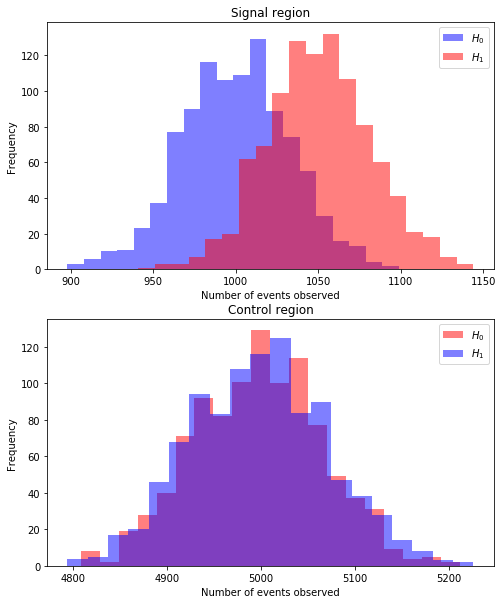

In [5]:
f, a= plt.subplots(nrows=2, figsize=(8,10))
a = a.flatten()
a[0].hist(observed_events_SR_H0, bins=20, color='b', alpha=0.5, label=r'$H_{0}$')
a[0].hist(observed_events_SR_H1, bins=20, color='r', alpha=0.5, label=r'$H_{1}$')
a[0].set_title("Signal region")
a[0].set_xlabel("Number of events observed")
a[0].set_ylabel("Frequency")
a[0].legend()
a[1].hist(observed_events_CR_H0, bins=20, color='r', alpha=0.5, label=r'$H_{0}$');
a[1].hist(observed_events_CR_H1, bins=20, color='b', alpha=0.5, label=r'$H_{1}$');
a[1].set_title("Control region")
a[1].legend()
a[1].set_xlabel("Number of events observed")
a[1].set_ylabel("Frequency")

In [6]:
def likelihood(mu, n, background):
    s0 = 1.0
    signal = mu * s0
    expected_events = signal + background
    likelihood = poisson.pmf(n, mu=expected_events)
    return likelihood

In [7]:
def log_likelihood(mu, n,background):
    s0 = 1
    signal = mu * s0
    expected_events = signal + background
    log_likelihood = poisson.logpmf(n, mu=expected_events)  
    return log_likelihood

In [8]:
## L_model = L(SR) * L(CR)
## ln L_model = ln(L(SR)*L(CR)) = ln(L(SR)) + ln(L(CR))

def model_log_likelihood(mu, bkg_CR, SR_events, CR_events):
    bkg_SR = bkg_CR * 0.2  # r=0.2
    ll_SR = log_likelihood(mu = mu, n = SR_events, background = bkg_SR)
    ll_CR = log_likelihood(mu = mu, n = CR_events, background = bkg_CR)
    return ll_SR+ll_CR

In [9]:
def neg_log_l_free(x, SR_events, CR_events):
    mu   = x[0]
    background_CR = x[1]
    log_likelihood_free = model_log_likelihood(mu, background_CR, SR_events, CR_events)
    return -log_likelihood_free

In [10]:
def neg_log_l_cond(x, mu, SR_events, CR_events):
    background_CR = x
    log_likelihood_cond = model_log_likelihood(mu, background_CR, SR_events, CR_events)
    return -log_likelihood_cond

In [11]:
def maximise_LL(SR_events,CR_events, mu):
    
    fit_result_free = minimize(neg_log_l_free, x0=[1.0, 5000.0], args=(SR_events,CR_events), method='Nelder-Mead') 
    LL_free = -fit_result_free['fun'] 
    parameter_MLE_free = fit_result_free['x']
    mu_fit_free = parameter_MLE_free[0]
    bkg_CR_free = parameter_MLE_free[1]
    
    fit_result_cond = minimize(neg_log_l_cond, x0=[5000.0], args=(mu,SR_events,CR_events), method='Nelder-Mead') 
    LL_cond = -fit_result_cond['fun'] 
    parameter_MLE_cond = fit_result_cond['x']
    bkg_CR_cond = parameter_MLE_cond

    return (LL_free, mu_fit_free, bkg_CR_free, LL_cond, bkg_CR_cond)

In [12]:
max_LL_results_H0 = [maximise_LL(SR,CR, mu_SR_H0) for SR,CR in zip(observed_events_SR_H0,observed_events_CR_H0)]
max_LL_results_H0 = np.array(max_LL_results_H0)
max_LL_results_H1 = [maximise_LL(SR,CR, mu_SR_H0) for SR,CR in zip(observed_events_SR_H1,observed_events_CR_H1)]
max_LL_results_H1 = np.array(max_LL_results_H1)

Distribution of LL_free and LL_cond for H0 and H1

C:\Users\Natasha\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


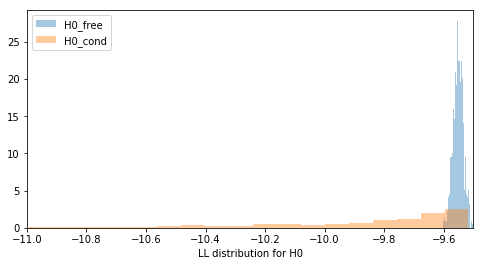

In [28]:
f,a = plt.subplots(figsize = (8,4))
a.hist(max_LL_results_H0[:,0], bins=50, alpha=0.4, label = 'H0_free',normed = True)
a.hist(max_LL_results_H0[:,3], bins=50, alpha=0.4, label='H0_cond', normed = True)
a.set_xlim(-11, -9.5)
a.set_xlabel("LL distribution for H0")
a.legend()

C:\Users\Natasha\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


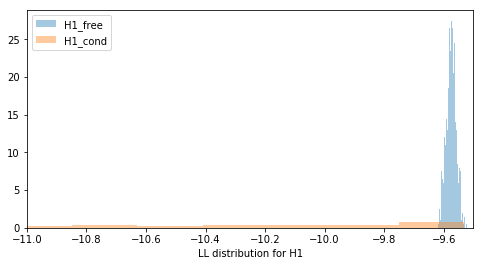

In [27]:
f,a = plt.subplots(figsize = (8,4))
a.hist(max_LL_results_H1[:,0], bins=50, alpha=0.4, label = 'H1_free',normed = True)
a.hist(max_LL_results_H1[:,3], bins=50, alpha=0.4, label='H1_cond', normed = True)
a.set_xlim(-11, -9.5)
a.set_xlabel("LL distribution for H1")
a.legend()

The unconditional mean is higher than the conditional as the both mu and bkg_CR are free to vary. There is still a spread in the unconditional mean as fluctuations in the number of events will cause mu_hat to fluctuate.

MLE mu_hat vs b_CR_hat distribution

Text(0.5,1,'Best fit $(\\hat{\\mu},\\hat{b}_{CR})$')

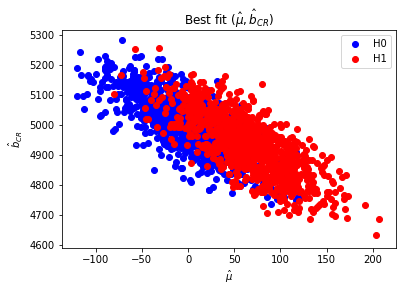

In [15]:
f,ax = plt.subplots()
ax.scatter(max_LL_results_H0[:,1], max_LL_results_H0[:,2], c='b', label=r"H0")
ax.scatter(max_LL_results_H1[:,1], max_LL_results_H1[:,2], c='r', label=r"H1")
ax.set_xlabel(r'$\hat{\mu}$')
ax.set_ylabel(r'$\hat{b}_{CR}$')
ax.legend()
ax.set_title(r"Best fit $(\hat{\mu},\hat{b}_{CR})$")

mu_hat gets worse if you observe more background events in the control region but the same number of events in the signal region.

Distribution for mu hat under H0 and H1

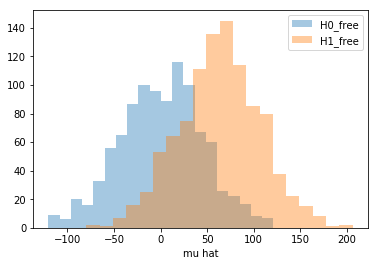

In [29]:
f,a = plt.subplots()
a.hist(max_LL_results_H0[:,1], bins=20, alpha=0.4 , label = "H0_free")
a.hist(max_LL_results_H1[:,1], bins=20, alpha=0.4, label = "H1_free")
a.set_xlabel("mu hat")
a.legend()

Distribution of the test statistic

In [21]:
LL_free_H0 = max_LL_results_H0[:,0]
LL_free_H1 = max_LL_results_H1[:,0]
LL_cond_H0 = max_LL_results_H0[:,3]
LL_cond_H1 = max_LL_results_H1[:,3]

t_H0 = -2.0*(LL_cond_H0 - LL_free_H0)
t_H1 = -2.0*(LL_cond_H1 - LL_free_H1) 

In [ ]:
Distribution of the test statistic.

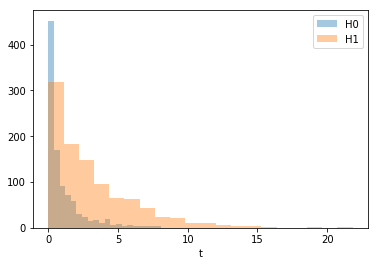

In [30]:
f,a = plt.subplots()
a.hist(t_H0, bins=20, alpha=0.4, label='H0')
a.hist(t_H1, bins=20, alpha=0.4, label='H1')
a.set_xlabel("t")
a.legend()

Can compare t values to the distribution.